## Occupancy grid mapping

The aim of this assignment is to implement a 2D occupancy grid mapping algorithm as described in the lecture. We provide data recorded by a robot using a 2D laser scanner in an indoor environment. 

The raw data is arranged in the following manner:

- `poses.data`: contains the **known** robot poses as it moves around the environment. Each line corresponds to the pose of the robot at a time instant

- `ranges.data`: contains 2d laser range measurements recorded by the robot. Each line corresponds to the range measurements taken from the corresponding robot poses.

---

### Log odds to probability

The occupancy calculations are usually performed using the log odds. We will need to convert between log odds and probabilities in this exercise. Implement the `logodds2prob` and `prob2logodds` functions. Verify that the conversion functions are correct for some test input. **[2.0]**

In [9]:
import numpy as np
import ex3 as ex

def prob2logodds(p):
    """Convert probability to log odds."""
    return np.log(p / (1 - p))

def logodds2prob(l):
    """Convert log odds to probability."""
    return 1 - (1 / (1 + np.exp(l)))

def world2map(pose, gridmap, map_res):
    """Convert world coordinates to map coordinates."""
    origin = np.array(gridmap.shape) / 2
    # Fix: Create a 2D array with correct shape
    new_pose = np.zeros((2,))
    new_pose[0] = np.round(pose[0] / map_res) + origin[0]
    new_pose[1] = np.round(pose[1] / map_res) + origin[1]
    return new_pose.astype(int)

def ranges2cells(r_ranges, w_pose, gridmap, map_res):
    """Convert range measurements to map cells."""
    # ranges to points
    r_points = ex.ranges2points(r_ranges)
    w_P = ex.v2t(w_pose)
    w_points = np.matmul(w_P, r_points)
    # convert to map frame
    m_points = np.zeros((2, w_points.shape[1]))
    for i in range(w_points.shape[1]):
        m_point = world2map(w_points[:2, i], gridmap, map_res)
        m_points[:, i] = m_point
    return m_points

def poses2cells(w_pose, gridmap, map_res):
    """Convert world poses to map cells."""
    return world2map(w_pose[:2], gridmap, map_res)

---
### Inverse sensor model

The occupancy grid mapping relies on as inverse sensor model to update the occupancy of a cell in the grid. For this exercise, we consider a simple sensor model, where the occupancy of cell $m_i$ is $P_{occ}$ if the measurement $z_t$ falls in that cell, otherwise the occupancy is $P_{free}$. 

However, if the cell $m_i$ is not in the perception field, the occupancy will be $P_{prior}$.

Use the  following probabilities in the implementation:
$$P_{occ} = 0.9, P_{free} = 0.35, P_{prior} = 0.5 $$

Implement the inverse sensor model function and verify that it is correct for some test input. **[2.0]**

In [10]:
def inv_sensor_model(cell, endpoint, prob_occ, prob_free):
    """
    Implement inverse sensor model
    cell: The cell to evaluate
    endpoint: The endpoint of the laser measurement
    prob_occ: Probability for occupied cells
    prob_free: Probability for free cells
    """
    # If the cell is at the endpoint, mark as occupied
    if np.array_equal(cell, endpoint):
        return prob_occ
    # If not at endpoint, mark as free
    return prob_free

---
### Occupancy grid mapping algorithm:

Implement the occupancy grid mapping algorithm as described in lecture slides. 

We provide some functions to make the implemntation easier.

- `ranges2cells` converts the raw measurements acquired by the robot (*ranges_raw*) into the correspoding cells of the gridmap.
- `poses2cells` converts the raw poses of the robot (*poses_raw*) into the correspoding cells of the gridmap.
- `bresenham` returns all the cells along a straigh line between two points in the gridmap.

Other parameters you may need in the implemntation are provided below.

Implement the `grid_mapping_with_known_poses` functionn and compute the resulting occupancy grid map using all the measurements provided in the data.

Plot the final occupancy gridmap using the `plot_gridmap` function. **[6.0]**


In [11]:
def grid_mapping_with_known_poses(ranges_raw, poses_raw, occ_gridmap, map_res, prob_occ, prob_free, prior):
    """
    Implement occupancy grid mapping
    ranges_raw: Raw range data from laser scanner
    poses_raw: Robot poses
    occ_gridmap: Initial occupancy grid map
    map_res: Map resolution
    prob_occ: Probability for occupied cells
    prob_free: Probability for free cells
    prior: Prior probability
    """
    # Convert initial probabilities to log odds
    gridmap_logodd = prob2logodds(occ_gridmap)
    prior_logodd = prob2logodds(prior)
    
    # Process each pose and corresponding range measurements
    for pose, ranges in zip(poses_raw, ranges_raw):
        # Convert range measurements to map coordinates
        endpoints = ranges2cells(ranges, pose, occ_gridmap, map_res)
        robot_pos = poses2cells(pose, occ_gridmap, map_res)
        
        # Process each laser endpoint
        for endpoint in endpoints.T:
            # Get cells along the beam using Bresenham's line algorithm
            cells = ex.bresenham(int(robot_pos[0]), int(robot_pos[1]), 
                            int(endpoint[0]), int(endpoint[1]))
            
            # Update log odds for all cells along the beam
            for cell in cells:
                if (0 <= cell[0] < occ_gridmap.shape[0] and 
                    0 <= cell[1] < occ_gridmap.shape[1]):
                    
                    # Calculate inverse sensor model probability
                    p = inv_sensor_model(cell, endpoint, prob_occ, prob_free)
                    
                    # Update log odds
                    gridmap_logodd[cell[0], cell[1]] = (
                        gridmap_logodd[cell[0], cell[1]] - 
                        prior_logodd + 
                        prob2logodds(p)
                    )
    
    # Convert final log odds back to probabilities
    return logodds2prob(gridmap_logodd)

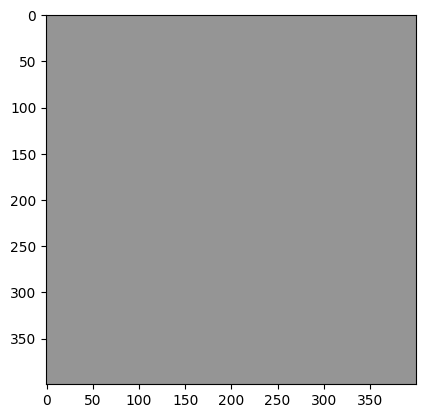

In [12]:
import ex3
import numpy as np
%matplotlib inline

map_size = 100
map_res = 0.25

prior = 0.50
prob_occ = 0.90
prob_free = 0.35

# load data
ranges_raw = np.loadtxt("ranges.data", delimiter=',', dtype='float')
poses_raw = np.loadtxt("poses.data", delimiter=',', dtype='float')

# initialize gridmap
occ_gridmap = ex3.init_gridmap(map_size, map_res)+prior
ex3.plot_gridmap(occ_gridmap)

C:\Users\Se227140\AppData\Local\Temp\ipykernel_16672\965261113.py:10: RuntimeWarning: overflow encountered in exp
  return 1 - (1 / (1 + np.exp(l)))


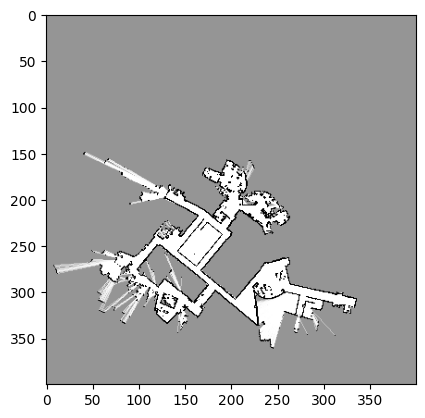

In [13]:
# Initialize and run the mapping
occ_gridmap = ex3.init_gridmap(map_size, map_res) + prior
final_map = grid_mapping_with_known_poses(
    ranges_raw, poses_raw, occ_gridmap, map_res, 
    prob_occ, prob_free, prior
)

# Plot the result
ex3.plot_gridmap(final_map)